# Introduction

This notebook presents **Keypoint Detection** using a **CNN** on the [CAT](https://www.kaggle.com/crawford/cat-dataset) dataset.

**Resources**

* [CAT (Kaggle)](https://www.kaggle.com/crawford/cat-dataset) - dataset used in this notebook
* [CAT (original)](https://archive.org/details/CAT_DATASET) - internet archive link to original data

# Imports

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import PIL
import PIL.ImageDraw

Limit TensorFlow GPU memory usage

In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True)  # init TF ...
config=tf.ConfigProto(gpu_options=gpu_options)  # w/o taking ...
with tf.Session(config=config): pass            # all GPU memory

# Configuration

Point this to dataset directory, folder should contain CAT_00, CAT_01 and so on.

In [3]:
dataset_location = '/home/marcin/Datasets/cat-dataset/cats/'

# Load Dataset

Subfolders within dataset

In [4]:
folders_all = ['CAT_00', 'CAT_01', 'CAT_02', 'CAT_03', 'CAT_04', 'CAT_05', 'CAT_06']

Get paths to all images

In [5]:
def build_image_files_list(folders):
    image_files_list = []
    for folder in folders:
        wild_path = os.path.join(dataset_location, folder, '*.jpg')
        image_files_list.extend(sorted(glob.glob(wild_path)))
    return image_files_list

In [6]:
image_paths_all = build_image_files_list(folders_all)

In [7]:
print('Nb images:', len(image_paths_all))
image_paths_all[:3]

Nb images: 9997


['/home/marcin/Datasets/cat-dataset/cats/CAT_00/00000001_000.jpg',
 '/home/marcin/Datasets/cat-dataset/cats/CAT_00/00000001_005.jpg',
 '/home/marcin/Datasets/cat-dataset/cats/CAT_00/00000001_008.jpg']

Helper to load keypoint data from *.cat* files

In [8]:
def load_keypoints(path):    
    """
        .cat is a single-line text file in format: 'nb_keypoints x1, y1, x2, y2, ...'
    """
    with open(path, 'r') as f:
        line = f.read().split()  # [nb_keypoints, x1, y1, x2, y2, ...]
    keypoints_nb = int(line[0])  # int
    keypoints_1d = np.array(line[1:], dtype=int)  # np.ndarray, [x1, y1, x2, y2, ...]
    keypoints_xy = keypoints_1d.reshape((-1, 2))  # np.ndarray, [[x1, y1], [x2, y2], ...]
    assert keypoints_nb == len(keypoints_xy)
    assert keypoints_nb == 9                # always nine keypoints, eyes, nose, two ears
    return keypoints_xy                     # np.ndarray, [[x1, y1], [x2, y2], ...]

Helper to draw keypoints on the image

In [11]:
def draw_keypoints(img, keypoints, r=2, c='red'):
    """Draw keypoints on PIL image"""
    draw = PIL.ImageDraw.Draw(img)
    for x, y in keypoints:
        draw.ellipse([x-r, y-r, x+r, y+r], c)
    return img

Open single image and load corresponding keypoints

In [12]:
example_path = image_paths_all[0]
img = PIL.Image.open(example_path)
kps = load_keypoints(example_path+'.cat')

Show example keypoints

In [14]:
display(kps)

array([[175, 160],
       [239, 162],
       [199, 199],
       [149, 121],
       [137,  78],
       [166,  93],
       [281, 101],
       [312,  96],
       [296, 133]])

Show example image

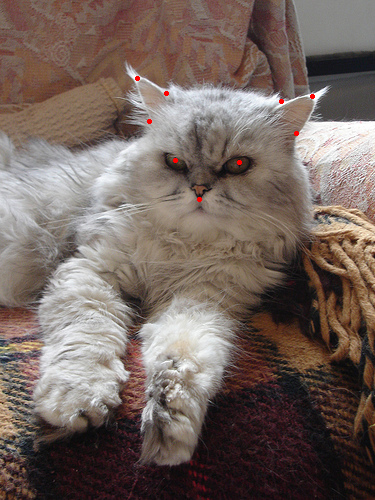

In [15]:
display(draw_keypoints(img.copy(), kps))

Helper to scale image and keypoints

In [16]:
def scale_img_kps(image, keypoints):
    width, height = image.size
    ratio_w = width / 224
    ratio_h = height / 224
    
    image_new = image.resize((224, 224), resample=PIL.Image.LANCZOS)
    
    keypoints_new = np.zeros_like(keypoints)
    keypoints_new[range(len(keypoints_new)), 0] = keypoints[:,0] / ratio_w
    keypoints_new[range(len(keypoints_new)), 1] = keypoints[:,1] / ratio_h
    
    return image_new, keypoints_new

Test it

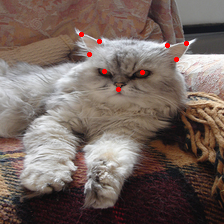

In [17]:
img2, kps2 = scale_img_kps(img, kps)
display(draw_keypoints(img2.copy(), kps2))

Helper to load and transform both input image and keypoints

In [18]:
def load_image_keypoints(image_path, keypoints_path):
    image = PIL.Image.open(image_path)
    keypoints = load_keypoints(keypoints_path)
    image_new, keypoints_new = scale_img_kps(image, keypoints)
    return image, keypoints, image_new, keypoints_new

Show couple more examples

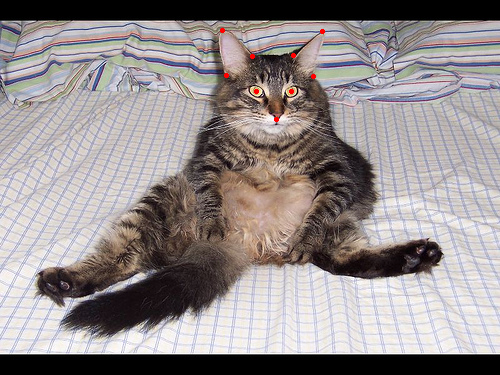

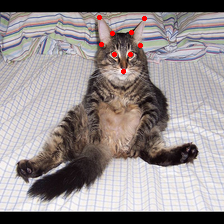

In [35]:
idx = 21

image, keypoints, image_new, keypoints_new = \
    load_image_keypoints(image_paths_all[idx], image_paths_all[idx]+'.cat')
display(draw_keypoints(image.copy(), keypoints))
display(draw_keypoints(image_new.copy(), keypoints_new))

**Preprocess Images**

In [65]:
images_list = []
keypoints_list = []
for i, image_path in enumerate(image_paths_all):
    _, _, image_new, keypoints_new = \
        load_image_keypoints(image_path, image_path+'.cat')
    
    image_arr = np.array(image_new)
    assert image_arr.shape == (224, 224, 3)
    assert 0 <= image_arr.min() <= 255

    images_list.append(image_arr)
    keypoints_list.append(keypoints_new)
    
    if i % 1000 == 0:
        print('i:', i)
        
images = np.array(images_list)
keypoints = np.array(keypoints_list)

i: 0
i: 1000
i: 2000
i: 3000
i: 4000
i: 5000
i: 6000
i: 7000
i: 8000
i: 9000


In [43]:
print('images.shape:', images.shape)
print('images.dtype:', images.dtype)
print('images.min()', images.min())
print('images.max()', images.max())

images.shape: (9997, 224, 224, 3)
images.dtype: uint8
images.min() 0
images.max() 255


Note that some keypoints are outside of image (e.g. when cat ear is cropped out)

In [44]:
print('keypoints.shape:', keypoints.shape)
print('keypoints.dtype:', keypoints.dtype)
print('keypoints.min()', keypoints.min())
print('keypoints.max()', keypoints.max())

keypoints.shape: (9997, 9, 2)
keypoints.dtype: int64
keypoints.min() -139
keypoints.max() 295


Sanity check

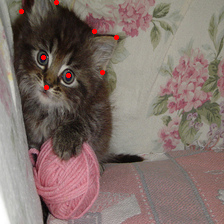

In [45]:
idx = 1

display(draw_keypoints(PIL.Image.fromarray(images[idx]).copy(), keypoints[idx]))

**Save Data**

In [92]:
dataset_npz = os.path.join(dataset_location, 'cats.npz')
dataset_npz

'/home/marcin/Datasets/cat-dataset/cats/cats.npz'

In [93]:
#uncomment if you realy want to save, will override existing
# np.savez(dataset_npz, images=images, keypoints=keypoints)

# Bottleneck Features

Preprocessed data file

In [38]:
dataset_npz = os.path.join(dataset_location, 'cats.npz')
dataset_npz

'/home/marcin/Datasets/cat-dataset/cats/cats.npz'

Load data

In [39]:
npzfile = np.load(dataset_npz)
images = npzfile['images']
keypoints = npzfile['keypoints']

Repeat definition in case we didn't run previous section

In [40]:
def draw_keypoints(img, keypoints, r=2, c='red'):
    """Draw keypoints on PIL image"""
    draw = PIL.ImageDraw.Draw(img)
    for x, y in keypoints:
        draw.ellipse([x-r, y-r, x+r, y+r], c)
    return img

Convert input into ImageNet format. This converts to float, scales and offsets to match distribution of ImageNet training data.

In [47]:
features = tf.keras.applications.mobilenet_v2.preprocess_input(images)
print('features.shape:', features.shape)
print('features.dtype:', features.dtype)
print('features.min()', features.min())
print('features.max()', features.max())

features.shape: (9997, 224, 224, 3)
features.dtype: float32
features.min() -1.0
features.max() 1.0


Convert targets to range -1..1

In [48]:
targets = (keypoints - 112) / 112
print('targets.shape:', targets.shape)
print('targets.dtype:', targets.dtype)
print('targets.min()', targets.min())
print('targets.max()', targets.max())

targets.shape: (9997, 9, 2)
targets.dtype: float64
targets.min() -2.2410714285714284
targets.max() 1.6339285714285714


Split into training and validation

In [65]:
split = 8000
train_images = images[:split]
train_features = features[:split]
train_targets = targets[:split]
valid_images = images[split:]
valid_features = features[split:]
valid_targets = targets[split:]

**Train end-to-end**

Define model

In [50]:
X_inputs = tf.keras.layers.Input(shape=(224, 224, 3))
mobilenetv2_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3), alpha=1.0, include_top=False,
    weights='imagenet', input_tensor=X_inputs, pooling='max')

X = tf.keras.layers.Dense(128, activation='relu')(mobilenetv2_model.layers[-1].output)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dense(18, activation='linear')(X)
X = tf.keras.layers.Reshape((9, 2))(X)

model = tf.keras.models.Model(inputs=X_inputs, outputs=X)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Show detection before training, most likely most keypoints will fall outside of image.

In [95]:
def test_validate():

    indices = [12, 21, 31, 40]
    tmp_images = valid_images[indices]
    tmp_inputs = valid_features[indices]
    predictions = model.predict(tmp_inputs)

    _, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=[12,4])

    for i, idx in enumerate(indices):
        img = PIL.Image.fromarray(valid_images[idx])
        kps = predictions[i] * 112 + 112
        axes[i].imshow(draw_keypoints(img, kps))
        
    plt.show()

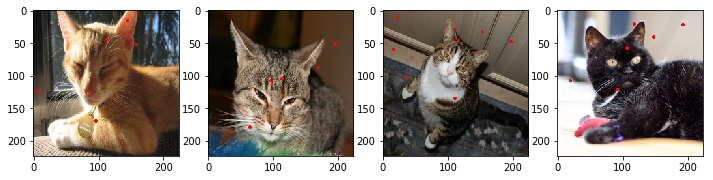

In [96]:
test_validate()

Custom callback for plotting

In [98]:
class CallbackPlot(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        pass

    def on_epoch_end(self, batch, logs={}):
        test_validate()

Run training

In [ ]:
#
#   Callbacks
#
tb_logdir = os.path.expanduser('~/logs/')
tb_counter  = len([log for log in os.listdir(tb_logdir) if 'cats' in log]) + 1
callback_tb = tf.keras.callbacks.TensorBoard(
    log_dir=tb_logdir + 'cats' + '_' + str(tb_counter), update_freq='batch')

callback_mc = tf.keras.callbacks.ModelCheckpoint(
    'weights_cats.h5', save_best_only=True, verbose=1)

callback_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, verbose=1)

callback_plt = CallbackPlot()

#
#   Train
#
model.fit(train_features, train_targets, epochs=50, batch_size=32, shuffle=True,
  validation_data=(valid_features, valid_targets),
  callbacks=[callback_tb, callback_mc, callback_lr, callback_plt]
)

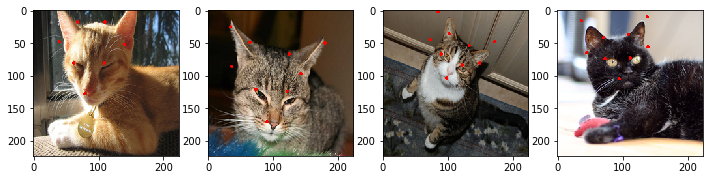

In [101]:
test_validate()